# Exercise sheet

Some general remarks about the exercises:
* For your convenience functions from the lecture are included below. Feel free to reuse them without copying to the exercise solution box.
* For each part of the exercise a solution box has been added, but you may insert additional boxes. Do not hesitate to add Markdown boxes for textual or LaTeX answers (via `Cell > Cell Type > Markdown`). But make sure to replace any part that says `YOUR CODE HERE` or `YOUR ANSWER HERE` and remove the `raise NotImplementedError()`.
* Please make your code readable by humans (and not just by the Python interpreter): choose informative function and variable names and use consistent formatting. Feel free to check the [PEP 8 Style Guide for Python](https://www.python.org/dev/peps/pep-0008/) for the widely adopted coding conventions or [this guide for explanation](https://realpython.com/python-pep8/).
* Make sure that the full notebook runs without errors before submitting your work. This you can do by selecting `Kernel > Restart & Run All` in the jupyter menu.
* Each sheet has 100 points worth of exercises. Note that only the grades of sheets number 2, 4, 6, 8 count towards the course examination. Submitting sheets 1, 3, 5, 7 & 9 is voluntary and their grades are just for feedback.

Please fill in your name here:

In [1]:
NAME = "Kees van Kempen"

---

__Exercise sheet 1__

Code from the lecture:

In [2]:
import numpy as np
import matplotlib.pylab as plt

rng = np.random.default_rng()
%matplotlib inline

def random_in_square():
    """Returns a random position in the square [-1,1)x[-1,1)."""
    return rng.uniform(-1,1,2)  

def is_in_circle(x):
    return np.dot(x,x) < 1

def simulate_number_of_hits(N):
    """Simulates number of hits in case of N trials in the pebble game."""
    number_hits = 0
    for i in range(N):
        position = random_in_square()
        if is_in_circle(position):
            number_hits += 1
    return number_hits

def random_in_disk():
    """Returns a uniform point in the unit disk via rejection."""
    position = random_in_square()
    while not is_in_circle(position):
        position = random_in_square()
    return position

def is_in_square(x):
    """Returns True if x is in the square (-1,1)^2."""
    return np.abs(x[0]) < 1 and np.abs(x[1]) < 1
    
def sample_next_position_naively(position,delta):
    """Keep trying a throw until it ends up in the square."""
    while True:
        next_position = position + delta*random_in_disk()
        if is_in_square(next_position):
            return next_position
    
def naive_markov_pebble(start,delta,N):
    """Simulates the number of hits in the naive Markov-chain version 
    of the pebble game."""
    number_hits = 0
    position = start
    for i in range(N):
        position = sample_next_position_naively(position,delta)
        if is_in_circle(position):
            number_hits += 1
    return number_hits

def naive_markov_pebble_generator(start,delta,N):
    """Same as naive_markov_pebble but only yields the positions."""
    position = start
    for i in range(N):
        position = sample_next_position_naively(position,delta)
        yield position

def sample_next_position(position,delta):
    """Attempt a throw and reject when outside the square."""
    next_position = position + delta*random_in_disk()
    if is_in_square(next_position):
        return next_position  # accept!
    else:
        return position  # reject!

def markov_pebble(start,delta,N):
    """Simulates the number of hits in the proper Markov-chain version of the pebble game."""
    number_hits = 0
    position = start
    for i in range(N):
        position = sample_next_position(position,delta)
        if is_in_circle(position):
            number_hits += 1
    return number_hits

def markov_pebble_generator(start,delta,N):
    """Same as markov_pebble but only yields the positions."""
    position = start
    for i in range(N):
        position = sample_next_position(position,delta)
        yield position

## Empirical convergence rate in the pebble game

__(a)__ Write a function `pi_stddev` that estimates the standard deviation $\sigma$ of the $\pi$-estimate using $n$ trials by running the direct-sampling pebble game $m$ times. Store this data for $n=2^4,2^5,\ldots,2^{14}$ and $m=200$ in an array. *Hint*: you may use the NumPy function [`np.std`](https://numpy.org/doc/stable/reference/generated/numpy.std.html). __(12 pts)__

In [3]:
def pi_stddev(n,m):
    """Estimate the standard deviation in the pi estimate in the case of n trials,
    based on m runs of the direct-sampling pebble game."""
    
    return np.std([simulate_number_of_hits(n)/n*4 for i in range(m)])
    
stddev_data = np.array([[2**k,pi_stddev(2**k,200)] for k in range(4,12)])
stddev_data

array([[1.60000000e+01, 4.08380950e-01],
       [3.20000000e+01, 2.90718399e-01],
       [6.40000000e+01, 2.12682826e-01],
       [1.28000000e+02, 1.51102637e-01],
       [2.56000000e+02, 1.12557602e-01],
       [5.12000000e+02, 6.94441168e-02],
       [1.02400000e+03, 5.69283874e-02],
       [2.04800000e+03, 3.67265915e-02]])

In [4]:
# If done correctly, your code should pass the following tests
from nose.tools import assert_almost_equal
assert_almost_equal(pi_stddev(2**3,1000),0.582,delta=0.03)
assert_almost_equal(pi_stddev(2**4,1000),0.411,delta=0.03)

__(b)__ Write a function `fit_power_law` that takes an array of $(n,\sigma)$ pairs and determines best-fit parameters $a,p$ for the curve $\sigma = a n^p$. This is best done by fitting a straight line to the data on a log-log scale ($\log\sigma=\log a+p\log n$). *Hint*: use [`curve_fit`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html) from SciPy. __(12 pts)__

In [5]:
import scipy.optimize

def fit_power_law(stddev_data):
    """Compute the best fit parameters a and p."""
    
    # Define the to be fitted function. We use the log, due to the calculation of the uncertainties.
    log_f = lambda n, a, p: np.log(a) + p*np.log(n)
    
    n, 𝜎 = stddev_data.T
    a_fit, p_fit = scipy.optimize.curve_fit(log_f, n, np.log(𝜎))[0]
    
    return a_fit, p_fit

In [6]:
from nose.tools import assert_almost_equal
assert_almost_equal(fit_power_law(np.array([[16.0,1.4],[32.0,1.1],[64.0,0.9]]))[0],3.36,delta=0.05)
assert_almost_equal(fit_power_law(np.array([[16.0,1.4],[32.0,1.1],[64.0,0.9]]))[1],-0.31,delta=0.03)

__(c)__ Plot the data against the fitted curve $\sigma = a n^p$ in a log-log plot. Don't forget to properly label your axes. *Hint*: use [`loglog`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.loglog.html) from matplotlib. __(12 pts)__

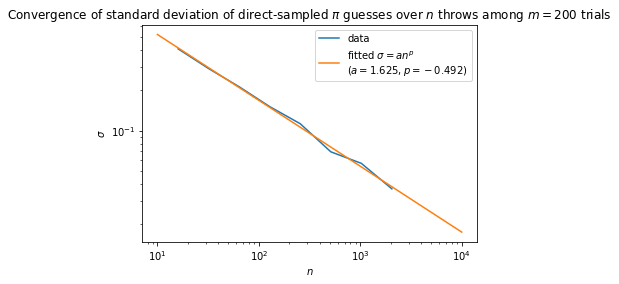

In [7]:
a_fit, p_fit = fit_power_law(stddev_data)

plt.figure()
plt.title("Convergence of standard deviation of direct-sampled $\pi$ guesses over $n$ throws among $m = 200$ trials")
plt.loglog(*stddev_data.T, label="data")
n_range = np.logspace(1, 4, 10)
plt.loglog(n_range, a_fit*n_range**p_fit,
           label="fitted $\sigma = an^p$\n($a = {:.3f}, p = {:.3f})$".format(a_fit, p_fit))
plt.xlabel("$n$")
plt.ylabel("$\sigma$")
plt.legend()
plt.show()

## Volume of a unit ball in other dimensions

In this exercise you will adapt the direct-sampling Monte Carlo method of the pebble game to higher dimensions to
estimate the $d$-dimensional volume of the $d$-dimensional ball of radius $1$.

__(a)__ Adapt the direct-sampling Monte Carlo method to the pebble game in a $d$-dimensional hypercube $(-1,1)^d$ with an inscribed $d$-dimensional unit ball. __(12 pts)__

In [8]:
def number_of_hits_in_d_dimensions(N,d):
    """Simulates number of hits in case of N trials in the d-dimensional direct-sampling pebble game."""

    def random_in_d_dimensional_box():
        """Returns a random position in the box [-1,1)^d."""
        return rng.uniform(-1,1,d)
        
    number_hits = 0
    for i in range(N):
        position = random_in_d_dimensional_box()
        if is_in_circle(position):
            number_hits += 1
    return number_hits

In [9]:
from nose.tools import assert_almost_equal
assert_almost_equal(number_of_hits_in_d_dimensions(100,1),100,delta=1)
assert_almost_equal(number_of_hits_in_d_dimensions(2000,3),1045,delta=50)

__(b)__ Compare your estimates for the volume $V_d$ of the $d$-dimensional unit ball for $N=10000$ trials and $d=1,2,\ldots,7$ to the [exact formula](https://en.wikipedia.org/wiki/Volume_of_an_n-ball) $V_d = \frac{\pi^{d/2}}{\Gamma(\tfrac{d}{2}+1)}$ in a plot. *Hint*: the Gamma function is available in `scipy.special.gamma`. __(12 pts)__

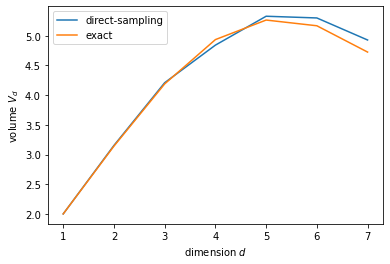

In [10]:
import scipy.special

def volume_d_ball(d):
    """Returns the volume of a d-dimensional unit ball."""
    return np.pi**(d/2)/scipy.special.gamma(d/2 + 1)

N = 10000
d_range = np.array(range(1, 8))
V_d_mc = [number_of_hits_in_d_dimensions(N, d)/N*2**d for d in d_range]

## Plotting
plt.figure()
plt.plot(d_range, V_d_mc, label="direct-sampling")
plt.plot(d_range, volume_d_ball(d_range), label="exact")
plt.xlabel("dimension $d$")
plt.ylabel("volume $V_d$")
plt.legend()
plt.show()

## Efficiency of the Metropolis algorithm and the 1/2-rule

In the lecture we mentioned the "1/2 rule" for Metropolis algorithms: if moves are rarely rejected then typically you do not explore the domain efficiently, while if most moves are rejected you are wasting efforts proposing moves. A good rule of thumb then is to aim for a rejection rate of $1/2$. In this exercise you are asked to test whether this rule of thumb makes any sense for the Markov-chain pebble game by varying the throwing range $\delta$. 

__(a)__ Estimate the mean square deviation $\mathbb{E}[(\tfrac{4\text{hits}}{\text{trials}} - \pi)^2 ]$ from $\pi$ for different values of $\delta$ ranging between $0$ and $3$, but fixed number of trials (say, 2000). For a decent estimate of the mean you will need at least $100$ repetitions. __(14 pts)__

In [11]:
N = 2000 # number of trials
m = 200  # number of repetitions
delta_range = np.linspace(0, 3, 10) # throwing ranges

p0 = np.array([0., 0.]) # starting position in origin
hits = np.zeros((len(delta_range), m), dtype=int)

for index_delta, delta in enumerate(delta_range):
    for i in range(m):
        hits[index_delta][i] = markov_pebble(p0, delta, N)

## Print the results
print("{:4}   {:6}   {:8}   {:<10}".format('N','delta','4*hits/trials','E[(4*hits/trials - pi)^2]'))
for index_delta, delta in enumerate(delta_range):
    pi_estimates = hits[index_delta]/N*4
    print("{:4}   {:1.4f}   {:1.4f}          {:1.3f}"
          .format(N, delta, np.mean(pi_estimates), np.mean((pi_estimates - np.pi)**2)))

N      delta    4*hits/trials   E[(4*hits/trials - pi)^2]
2000   0.0000   4.0000          0.737
2000   0.3333   3.1625          0.015
2000   0.6667   3.1381          0.006
2000   1.0000   3.1450          0.006
2000   1.3333   3.1471          0.004
2000   1.6667   3.1429          0.006
2000   2.0000   3.1508          0.008
2000   2.3333   3.1429          0.011
2000   2.6667   3.1362          0.015
2000   3.0000   3.1297          0.016


__(b)__ Measure the rejection rate for the same simulations as in (a). __(14 pts)__

In [12]:
# To calculate the rejection rate, we need to know the positions. I will copy
# and adapt the above code and the code in the markov_pebble function as is
# provided at the beginning of this document.

N = 2000 # number of trials
m = 200  # number of repetitions
delta_range = np.linspace(0, 3, 10) # throwing ranges

p0 = np.array([0., 0.]) # starting position in origin
hits = np.zeros((len(delta_range), m), dtype=int)
rejections = np.zeros((len(delta_range), m), dtype=int)

for index_delta, delta in enumerate(delta_range):
    for i in range(m):
        prev_position = None
        for position in markov_pebble_generator(p0,delta,N):
            if np.all(position == prev_position):
                rejections[index_delta][i] += 1
            if is_in_circle(position):
                hits[index_delta][i] += 1
            prev_position = position

## Print the results
print("{:4}   {:6}   {:8}   {:<10}    {:<10}"
      .format('N','delta','4*hits/trials','E[(4*hits/trials - pi)^2]', 'rejection rate'))
for index_delta, delta in enumerate(delta_range):
    pi_estimates = hits[index_delta]/N*4
    print("{:4}   {:1.4f}   {:1.4f}          {:1.3f}                        {:1.3f}"
          .format(N, delta, np.mean(pi_estimates), np.mean((pi_estimates - np.pi)**2), np.mean(rejections[index_delta]/N)))

N      delta    4*hits/trials   E[(4*hits/trials - pi)^2]    rejection rate
2000   0.0000   4.0000          0.737                        0.999
2000   0.3333   3.1449          0.014                        0.138
2000   0.6667   3.1442          0.005                        0.265
2000   1.0000   3.1463          0.006                        0.385
2000   1.3333   3.1392          0.005                        0.495
2000   1.6667   3.1386          0.006                        0.598
2000   2.0000   3.1403          0.006                        0.688
2000   2.3333   3.1404          0.010                        0.766
2000   2.6667   3.1358          0.013                        0.821
2000   3.0000   3.1525          0.017                        0.858


__(c)__ Plot both the mean square deviation and the rejection rate as function of $\delta$. How well does the 1/2 rule apply in this situation? __(12 pts)__

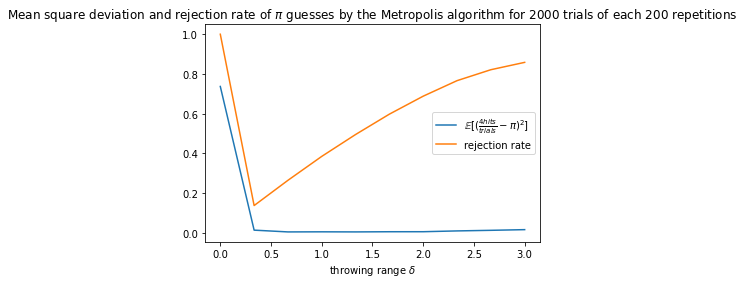

The rejection rate is around 1/2 for delta = 1.3333, which also yields near lowest mean square deviation to pi.
The rule of thumb works quite nicely in this case, although it does not yields the best result.


In [13]:
plt.figure()
plt.title("Mean square deviation and rejection rate of $\\pi$ guesses by the Metropolis algorithm for {} trials of each {} repetitions".format(N, m))
plt.plot(delta_range, np.mean((hits/N*4 - np.pi)**2, axis=1), label="$\mathbb{E}[(\\frac{4hits}{trials} - \\pi)^2]$")
plt.plot(delta_range, np.mean(rejections/N, axis=1), label="rejection rate")
plt.xlabel("throwing range $\\delta$")
plt.legend()
plt.rc('legend', fontsize=13)
plt.show()

print("The rejection rate is around 1/2 for delta = 1.3333, which also yields near lowest mean square deviation to pi.")
print("The rule of thumb works quite nicely in this case, although it does not yields the best result.")